# Проект по предсказанию вероятности совершения покупки

Описание проекта: интернет-магазин собирает историю покупателей, проводит рассылки предложений и планирует будущие продажи. Для оптимизации процессов надо выделить пользователей, которые готовы совершить покупку в ближайшее время.

Цель проекта - предсказать вероятность покупки в течение 90 дней.

Задачи:
- Изучить данные
- Разработать полезные признаки
- Создать модель для классификации пользователей
- Улучшить модель и максимизировать метрику roc_auc
- Выполнить тестирование

План работ:

- загрузка и ознакомление с данными,
- предварительная обработка,
- исследовательский анализ,
- разработка новых синтетических признаков,
- проверка на мультиколлинеарность,
- отбор финального набора обучающих признаков,
- выбор и обучение моделей,
- итоговая оценка качества предсказания лучшей модели.

<div style="background: #bbdb92">Зеленым фоном подсвечены выводы по разделам.</div>
<div style="background: #f5f7c4">Желтым фоном подсвечены промежуточные комментарии.</div>

## Установка и импорт необходимых библиотек и модулей

In [1]:
!pip install matplotlib -q
!pip install scikit-learn --upgrade -q
!pip install phik -q

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import phik

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.impute import SimpleImputer 
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import roc_auc_score

In [3]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
#определяем константы

TEST_SIZE=0.25
RANDOM_STATE=42

## Загрузка и ознакомление с данными

In [5]:
purchases = pd.read_csv("/Users/ADMINX/Project marketplace/apparel-purchases.csv")

In [6]:
purchases.head()

,client_id,quantity,price,category_ids,date,message_id
0,1515915625468169594,1,1999.0,"['4', '28', '57', '431']",2022-05-16,1515915625468169594-4301-627b661e9736d
1,1515915625468169594,1,2499.0,"['4', '28', '57', '431']",2022-05-16,1515915625468169594-4301-627b661e9736d
2,1515915625471138230,1,6499.0,"['4', '28', '57', '431']",2022-05-16,1515915625471138230-4437-6282242f27843
3,1515915625471138230,1,4999.0,"['4', '28', '244', '432']",2022-05-16,1515915625471138230-4437-6282242f27843
4,1515915625471138230,1,4999.0,"['4', '28', '49', '413']",2022-05-16,1515915625471138230-4437-6282242f27843


In [7]:
purchases.shape

(202208, 6)

In [8]:
purchases.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202208 entries, 0 to 202207
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   client_id     202208 non-null  int64  
 1   quantity      202208 non-null  int64  
 2   price         202208 non-null  float64
 3   category_ids  202208 non-null  object 
 4   date          202208 non-null  object 
 5   message_id    202208 non-null  object 
dtypes: float64(1), int64(2), object(3)
memory usage: 9.3+ MB


In [9]:
messages = pd.read_csv("/Users/ADMINX/Project marketplace/apparel-messages.csv")

In [10]:
messages.head()

,bulk_campaign_id,client_id,message_id,event,channel,date,created_at
0,4439,1515915625626736623,1515915625626736623-4439-6283415ac07ea,open,email,2022-05-19,2022-05-19 00:14:20
1,4439,1515915625490086521,1515915625490086521-4439-62834150016dd,open,email,2022-05-19,2022-05-19 00:39:34
2,4439,1515915625553578558,1515915625553578558-4439-6283415b36b4f,open,email,2022-05-19,2022-05-19 00:51:49
3,4439,1515915625553578558,1515915625553578558-4439-6283415b36b4f,click,email,2022-05-19,2022-05-19 00:52:20
4,4439,1515915625471518311,1515915625471518311-4439-628341570c133,open,email,2022-05-19,2022-05-19 00:56:52


In [11]:
messages.shape

(12739798, 7)

In [12]:
messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12739798 entries, 0 to 12739797
Data columns (total 7 columns):
 #   Column            Dtype 
---  ------            ----- 
 0   bulk_campaign_id  int64 
 1   client_id         int64 
 2   message_id        object
 3   event             object
 4   channel           object
 5   date              object
 6   created_at        object
dtypes: int64(2), object(5)
memory usage: 680.4+ MB


In [13]:
target = pd.read_csv("/Users/ADMINX/Project marketplace/apparel-target_binary.csv")

In [14]:
target.head()

,client_id,target
0,1515915625468060902,0
1,1515915625468061003,1
2,1515915625468061099,0
3,1515915625468061100,0
4,1515915625468061170,0


In [15]:
target.shape

(49849, 2)

In [16]:
target.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49849 entries, 0 to 49848
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   client_id  49849 non-null  int64
 1   target     49849 non-null  int64
dtypes: int64(2)
memory usage: 779.0 KB


<div style="background: #bbdb92"><b>Выводы по разделу "Загрузка и ознакомление с данными"</b>
<br><br><div style="background: #bbdb92">Файлы загружены:
<br><br>purchases - данные о покупках клиентов по дням и по товарам, поля:
    
- client_id идентификатор клиента
- quantity количество единиц товара
- price цена товара
- category_ids идентификаторы категорий
- date дата покупки
- message_id идентификатор сообщения из рассылки

messages - рассылки, которые были отправлены клиентам из таблицы покупок, поля:

- bulk_campaign_id идентификатор рассылки
- client_id идентификатор клиента
- message_id идентификатор сообщения
- event действие с сообщением (отправлено, открыто, покупка...)
- channel канал рассылки
- date дата действия
- created_at дата-время полностью

target - совершит ли клиент покупку в течение следующих 90 дней, поля:

- client_id идентификатор клиента
- target клиент совершил покупку в целевом периоде

Данные соответствуют описанию данных.
<br><br>Нужно преобразовать признаки с датами в тип datetime.</div>

## Предобработка и разведочный анализ данных

<div style="background: #f5f7c4">Заменим тип данных столбцов с датами на тип datetime.</div>

In [17]:
purchases['date'] = pd.to_datetime(purchases['date'])
messages['date'] = pd.to_datetime(messages['date'])
messages['created_at'] = pd.to_datetime(messages['created_at'])

<div style="background: #f5f7c4">Проверим наличие пропусков в файлах.

In [18]:
purchases.isna().sum()

client_id       0
quantity        0
price           0
category_ids    0
date            0
message_id      0
dtype: int64

In [19]:
messages.isna().sum()

bulk_campaign_id    0
client_id           0
message_id          0
event               0
channel             0
date                0
created_at          0
dtype: int64

In [20]:
target.isna().sum()

client_id    0
target       0
dtype: int64

<div style="background: #f5f7c4">Пропусков не обнаружено. Проверим наличие явных дубликатов.</div>

In [21]:
purchases.duplicated().sum()

73020

In [22]:
messages.duplicated().sum()

48610

In [23]:
target.duplicated().sum()

0

In [24]:
#удалим явные дубликаты

purchases.drop_duplicates(inplace=True)
messages.drop_duplicates(inplace=True)

<div style="background: #f5f7c4">Явные дубликаты удалены. Проверим наличие НЕявных дубликатов.</div>

In [25]:
messages['event'].unique()

array(['open', 'click', 'purchase', 'send', 'unsubscribe', 'hbq_spam',
       'hard_bounce', 'subscribe', 'soft_bounce', 'complain', 'close'],
      dtype=object)

In [26]:
messages['channel'].unique()

array(['email', 'mobile_push'], dtype=object)

<div style="background: #f5f7c4">Неявных дубликатов не обнаружено.</div>

<div style="background: #f5f7c4">Рассмотрим подробнее признаки датасета с покупками purchases.</div>

In [27]:
purchases_cols = ['client_id', 'quantity', 'category_ids', 'message_id']

for col in purchases_cols:
    print(purchases[col].value_counts())
    print()

client_id
1515915625853312319    156
1515915625500232103     75
1515915625470860261     66
1515915625912328708     56
1515915625559931867     53
                      ... 
1515915625678975113      1
1515915625658038963      1
1515915625627069813      1
1515915625587464314      1
1515915626010443624      1
Name: count, Length: 49849, dtype: int64

quantity
1     128352
2        714
3         86
4         12
6          4
10         3
15         3
5          3
25         2
20         2
30         2
13         1
18         1
8          1
9          1
7          1
Name: count, dtype: int64

category_ids
['4', '28', '57', '431']            6191
['4', '28', '244', '432']           4835
['4', '28', '260', '420']           4421
['4', '28', '275', '421']           3309
['2', '18', '258', '441']           3175
                                    ... 
['4', '27', '336', '1854']             1
['4', '44', '1600']                    1
['4', '27', '353', '1799']             1
['5963', '5959', '6021', 

In [28]:
purchases['date'].dt.year.value_counts()

date
2023    65184
2022    57429
2024     6575
Name: count, dtype: int64

<div style="background: #f5f7c4">Большинство покупок содержит одну единицу товара, есть постоянные клиенты, совершившие от 2 до 156 покупок в магазине. Покупки совершались за период 2022-2024гг, при этом в 2023 было больше всего покупок. В датасете 933 уникальные категории товаров. </div>

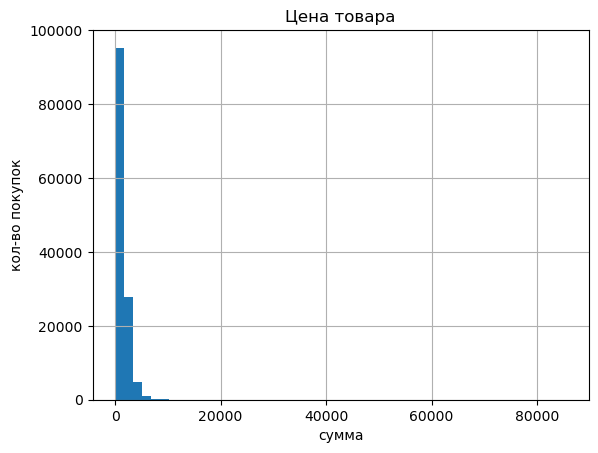

In [29]:
purchases['price'].hist(bins=50)
plt.title('Цена товара')
plt.ylabel('кол-во покупок')
plt.xlabel('сумма')
plt.show()

In [30]:
purchases.query('price > 15000')

,client_id,quantity,price,category_ids,date,message_id
6018,1515915625692218402,1,48499.0,"['4', '29', '312', '1576']",2022-06-01,1515915625489907961-4679-62972222453b3
12994,1515915625494529950,1,16499.0,"['4', '29', '313', '1574']",2022-06-10,1515915625494529950-4832-62a1969869bb0
24373,1515915625489947869,1,19499.0,"['4', '29', '310', '500']",2022-07-16,1515915625489947869-5112-62b580d8232f3
24374,1515915625489947869,1,16999.0,"['4', '29', '310', '500']",2022-07-16,1515915625489947869-5112-62b580d8232f3
25327,1515915625468070051,1,20499.0,"['4', '29', '310', '1577']",2022-07-21,1515915625468070051-5505-62d65dca6e294
...,...,...,...,...,...,...
201116,1515915625488243479,1,18500.0,"['4', '29', '310', '1577']",2024-02-14,1515915625488243479-14641-65cb23e8dc49b
201446,1515915625953187492,1,28400.0,"['4', '29', '313', '1574']",2024-02-14,1515915625953187492-14488-65a79766e8625
201447,1515915625953187492,1,18999.0,"['4', '29', '310', '1577']",2024-02-14,1515915625953187492-14488-65a79766e8625
201498,1515915625995466015,1,36999.0,"['4', '29', '310', '1577']",2024-02-14,1515915625488243479-14641-65cb23e8dc49b


<div style="background: #f5f7c4">Признак "цена" содержит выбросы, 111 с ценой за товар выше 15000 можем удалить.</div>

In [31]:
purchases = purchases.query('price < 15000')

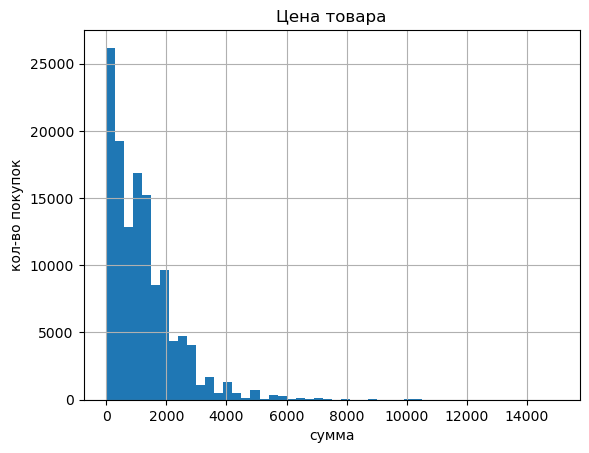

In [32]:
purchases['price'].hist(bins=50)
plt.title('Цена товара')
plt.ylabel('кол-во покупок')
plt.xlabel('сумма')
plt.show()

<div style="background: #f5f7c4">Теперь видим, что большая часть покупок совершалась в пределах 2000 за покупку.</div>

<div style="background: #f5f7c4">Рассмотрим подробнее признаки датасета с сообщениями messages.</div>

In [33]:
messages_cols = ['client_id', 'bulk_campaign_id', 'message_id', 'event', 'channel']

for col in messages_cols:
    print(messages[col].value_counts())
    print()

client_id
1515915625516327994    3088
1515915625625548006    3067
1515915625804998560    2721
1515915625489071904    1845
1515915625489095763    1427
                       ... 
1515915625558767774       1
1515915625577289455       1
1515915625840706531       1
1515915625977549113       1
1515915625500865072       1
Name: count, Length: 53329, dtype: int64

bulk_campaign_id
14272    104060
14276     63362
4679      50621
11760     45745
14081     44067
          ...  
657           1
1391          1
1080          1
548           1
4478          1
Name: count, Length: 2709, dtype: int64

message_id
1515915625489095763-6251-6311b13a4cf78     1427
1515915625490540122-6973-633edf707840d      438
1515915625490241385-6973-633edf70723d8      438
1515915625629509124-6374-63241bd1541d5      286
1515915625488270582-3433-6232d6007e929      249
                                           ... 
1515915625489968543-12052-64426bfcee0e6       1
1515915625500268486-12052-64426bfce782f       1
15159156254

<div style="background: #f5f7c4">Строку с одним значением close признака event можно удалить.</div>

In [34]:
messages = messages.query("event != 'close'")

In [35]:
messages['date'].dt.year.value_counts()

date
2023    7628147
2022    3454342
2024    1608698
Name: count, dtype: int64

In [36]:
messages['created_at'].dt.year.value_counts()

created_at
2023    7628147
2022    3454342
2024    1608698
Name: count, dtype: int64

In [37]:
messages['created_at'].dt.year - messages['date'].dt.year

0           0
1           0
2           0
3           0
4           0
           ..
12739793    0
12739794    0
12739795    0
12739796    0
12739797    0
Length: 12691187, dtype: int32

<div style="background: #f5f7c4">Было совершено 2.709 рассылок по 53.329 клиентам. По большей части реакция на рассылки положительная (открыли, кликнули, совершили покупку). Мобильных пуш уведомлений отправлено больше, чем емэйл-рассылок. Частоты по дате и по дате создания идентичны, это одни и те же даты, можем удалить столбец "дата создания" как повторяющийся.</div>

In [38]:
messages = messages.drop('created_at', axis=1)

<div style="background: #f5f7c4">Рассмотрим подробнее признаки датасета target.</div>

In [39]:
target['client_id'].value_counts()

client_id
1515915625468060902    1
1515915625586058988    1
1515915625585957439    1
1515915625585959517    1
1515915625585965079    1
                      ..
1515915625491478211    1
1515915625491478669    1
1515915625491478747    1
1515915625491478978    1
1515915626010443624    1
Name: count, Length: 49849, dtype: int64

In [40]:
target['target'].value_counts()

target
0    48888
1      961
Name: count, dtype: int64

<div style="background: #f5f7c4">В target все индентификаторы клиентов уникальны, 48.888 клиентов совершали покупку в течение 90 дней.</div>

<div style="background: #bbdb92"><b>Выводы по разделу "Предобработка и разведочный анализ данных"</b>
<br><br><b>Предобработка:</b>

- Типы данных в файлах messages и purchases с датами заменили на datetime.
- Удалили явные дубликаты в файлах messages и purchase и лишний столбец "дата создания" в файле messages. 
- Удалили выбросы в файле purchases (цена > 15.000).

<b>Анализ данных:</b>

Покупки:

- Большинство покупок содержит одну единицу товара
- Есть постоянные клиенты, совершившие от 2 до 156 покупок в магазине
- Покупки совершались за период 2022-2024гг, при этом в 2023 было больше всего покупок.
- В датасете 933 уникальные категории товаров.

Рекламные рассылки:

- Было совершено 2.709 рассылок по 53.329 клиентам
- По большей части реакция на рассылки положительная (открыли, кликнули, совершили покупку)
- Мобильных пуш уведомлений отправлено больше, чем емэйл-рассылок

Целевой признак:

- 48.888 клиентов из 49.849 совершали покупку в течение 90 дней (дисбаланс классов).
</div>

## Объединение данных

<div style="background: #f5f7c4">Для начала создадим некоторые синтетические признаки.
</div>

In [41]:
# в таблице purchases добавим признак "общая сумма покупки"

purchases['total_sum'] = purchases['quantity']*purchases['price']
#purchases = purchases.drop(['quantity', 'price'], axis=1)

In [42]:
# в таблице purchases из category_ids выделим главную категорию, ту, что на первом месте

purchases['category_ids'] = purchases['category_ids'].str.replace("[", "").str.replace("]", "").str.replace("'", "")

purchases['main_category'] = purchases['category_ids'].str.split(",").str[0]
purchases = purchases.drop('category_ids', axis=1)
purchases.head()

,client_id,quantity,price,date,message_id,total_sum,main_category
0,1515915625468169594,1,1999.0,2022-05-16,1515915625468169594-4301-627b661e9736d,1999.0,4
1,1515915625468169594,1,2499.0,2022-05-16,1515915625468169594-4301-627b661e9736d,2499.0,4
2,1515915625471138230,1,6499.0,2022-05-16,1515915625471138230-4437-6282242f27843,6499.0,4
3,1515915625471138230,1,4999.0,2022-05-16,1515915625471138230-4437-6282242f27843,4999.0,4
4,1515915625471138230,1,4999.0,2022-05-16,1515915625471138230-4437-6282242f27843,4999.0,4


In [43]:
# сгруппируем клиентов по id и добавим столбец с общей суммой покупок 

purchases_groupby_client_id = purchases.drop(columns=['quantity', 'price', 'date', 'message_id', 'main_category']).groupby(by='client_id').sum()
purchases_groupby_client_id.head()

,total_sum
client_id,
1515915625468060902,4795.0
1515915625468061003,14135.0
1515915625468061099,299.0
1515915625468061100,1049.0
1515915625468061170,14102.0


In [44]:
# добавим столбец с кол-вом купленных товаров 

purchases_groupby_client_id['quantity'] = purchases.drop(columns=['main_category', 'price', 'date', 'message_id', 'total_sum']).groupby(by='client_id')['quantity'].sum()
purchases_groupby_client_id.head()

,total_sum,quantity
client_id,,
1515915625468060902,4795.0,5
1515915625468061003,14135.0,6
1515915625468061099,299.0,1
1515915625468061100,1049.0,1
1515915625468061170,14102.0,8


In [45]:
# добавим столбец с самой часто встречающейся категорией покупок

purchases_groupby_client_id['main_category'] = purchases.drop(columns=['quantity', 'price', 'date', 'message_id', 'total_sum']).groupby(by='client_id')['main_category'].agg(pd.Series.mode)
purchases_groupby_client_id.head()

,total_sum,quantity,main_category
client_id,,,
1515915625468060902,4795.0,5,4
1515915625468061003,14135.0,6,4
1515915625468061099,299.0,1,4
1515915625468061100,1049.0,1,4
1515915625468061170,14102.0,8,4


In [46]:
# добавим столбец с датой последней покупки

# purchases_groupby_client_id['last_date_purchase'] = purchases.drop(columns=['main_category', 'quantity', 'price', 'message_id', 'total_sum']).groupby(by='client_id')['date'].max()
# purchases_groupby_client_id.head()

In [47]:
# сгруппируем клиентов по id и добавим столбец с общим количеством отправленных рассылок

messages_groupby_client_id = messages.drop(columns=['message_id', 'event', 'channel', 'date']).groupby(by='client_id').count()

messages_groupby_client_id.columns = ['campaign_count']
messages_groupby_client_id.head()

,campaign_count
client_id,
1515915625468060902,177
1515915625468061003,165
1515915625468061099,276
1515915625468061100,428
1515915625468061170,293


In [48]:
# добавим столбец с датой последней рассылки

# messages_groupby_client_id['last_date_message'] = messages.drop(columns=['bulk_campaign_id', 'message_id', 'event', 'channel']).groupby(by='client_id')['date'].max()
# messages_groupby_client_id.head()

In [49]:
# добавим столбцы с подсчетом кол-ва рассылок, отсутсвующие значения заменим нулями

messages_groupby_client_id_pivot = messages.pivot_table(index='client_id', columns='event', aggfunc='size', fill_value=0)
messages_groupby_client_id_pivot.columns = [f'message_{col}' for col in messages_groupby_client_id_pivot.columns]
messages_groupby_client_id_pivot.head()

,message_click,message_complain,message_hard_bounce,message_hbq_spam,message_open,message_purchase,message_send,message_soft_bounce,message_subscribe,message_unsubscribe
client_id,,,,,,,,,,
1515915625468060902,10,0,0,0,35,5,126,0,0,1
1515915625468061003,5,0,0,0,5,1,154,0,0,0
1515915625468061099,8,0,2,0,51,0,215,0,0,0
1515915625468061100,1,0,1,0,157,1,267,1,0,0
1515915625468061170,16,0,0,0,31,3,243,0,0,0


In [50]:
# добавим столбцы с подсчетом каналов рассылок, отсутсвующие значения заменим нулями

messages_groupby_client_id_pivot_1 = messages.pivot_table(index='client_id', columns='channel', aggfunc='size', fill_value=0)
messages_groupby_client_id_pivot_1.columns = [f'channel_{col}' for col in messages_groupby_client_id_pivot_1.columns]
messages_groupby_client_id_pivot_1.head()

,channel_email,channel_mobile_push
client_id,,
1515915625468060902,177,0
1515915625468061003,165,0
1515915625468061099,182,94
1515915625468061100,0,428
1515915625468061170,202,91


In [51]:
#объединим полученные сводные таблицы

messages_groupby_client_id_pivot_1 = messages_groupby_client_id_pivot_1.merge(messages_groupby_client_id_pivot, on='client_id', how='left')
messages_groupby_client_id_pivot_1.head()

,channel_email,channel_mobile_push,message_click,message_complain,message_hard_bounce,message_hbq_spam,message_open,message_purchase,message_send,message_soft_bounce,message_subscribe,message_unsubscribe
client_id,,,,,,,,,,,,
1515915625468060902,177,0,10,0,0,0,35,5,126,0,0,1
1515915625468061003,165,0,5,0,0,0,5,1,154,0,0,0
1515915625468061099,182,94,8,0,2,0,51,0,215,0,0,0
1515915625468061100,0,428,1,0,1,0,157,1,267,1,0,0
1515915625468061170,202,91,16,0,0,0,31,3,243,0,0,0


In [52]:
# объединим полученную таблицу с данными по сообщениям и покупкам

messages_groupby_client_id_pivot_1 = messages_groupby_client_id_pivot_1.merge(messages_groupby_client_id, on='client_id', how='left')
messages_groupby_client_id_pivot_1.head()

,channel_email,channel_mobile_push,message_click,message_complain,message_hard_bounce,message_hbq_spam,message_open,message_purchase,message_send,message_soft_bounce,message_subscribe,message_unsubscribe,campaign_count
client_id,,,,,,,,,,,,,
1515915625468060902,177,0,10,0,0,0,35,5,126,0,0,1,177
1515915625468061003,165,0,5,0,0,0,5,1,154,0,0,0,165
1515915625468061099,182,94,8,0,2,0,51,0,215,0,0,0,276
1515915625468061100,0,428,1,0,1,0,157,1,267,1,0,0,428
1515915625468061170,202,91,16,0,0,0,31,3,243,0,0,0,293


In [53]:
df = messages_groupby_client_id_pivot_1.join(purchases_groupby_client_id, on='client_id', how='left')
df.head()

,channel_email,channel_mobile_push,message_click,message_complain,message_hard_bounce,message_hbq_spam,message_open,message_purchase,message_send,message_soft_bounce,message_subscribe,message_unsubscribe,campaign_count,total_sum,quantity,main_category
client_id,,,,,,,,,,,,,,,,
1515915625468060902,177,0,10,0,0,0,35,5,126,0,0,1,177,4795.0,5.0,4
1515915625468061003,165,0,5,0,0,0,5,1,154,0,0,0,165,14135.0,6.0,4
1515915625468061099,182,94,8,0,2,0,51,0,215,0,0,0,276,299.0,1.0,4
1515915625468061100,0,428,1,0,1,0,157,1,267,1,0,0,428,1049.0,1.0,4
1515915625468061170,202,91,16,0,0,0,31,3,243,0,0,0,293,14102.0,8.0,4


In [54]:
target = target.merge(df, on='client_id', how='left')
target.head()

,client_id,target,channel_email,channel_mobile_push,message_click,message_complain,message_hard_bounce,message_hbq_spam,message_open,message_purchase,message_send,message_soft_bounce,message_subscribe,message_unsubscribe,campaign_count,total_sum,quantity,main_category
0,1515915625468060902,0,177.0,0.0,10.0,0.0,0.0,0.0,35.0,5.0,126.0,0.0,0.0,1.0,177.0,4795.0,5.0,4
1,1515915625468061003,1,165.0,0.0,5.0,0.0,0.0,0.0,5.0,1.0,154.0,0.0,0.0,0.0,165.0,14135.0,6.0,4
2,1515915625468061099,0,182.0,94.0,8.0,0.0,2.0,0.0,51.0,0.0,215.0,0.0,0.0,0.0,276.0,299.0,1.0,4
3,1515915625468061100,0,0.0,428.0,1.0,0.0,1.0,0.0,157.0,1.0,267.0,1.0,0.0,0.0,428.0,1049.0,1.0,4
4,1515915625468061170,0,202.0,91.0,16.0,0.0,0.0,0.0,31.0,3.0,243.0,0.0,0.0,0.0,293.0,14102.0,8.0,4


In [55]:
target.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49849 entries, 0 to 49848
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   client_id            49849 non-null  int64  
 1   target               49849 non-null  int64  
 2   channel_email        41982 non-null  float64
 3   channel_mobile_push  41982 non-null  float64
 4   message_click        41982 non-null  float64
 5   message_complain     41982 non-null  float64
 6   message_hard_bounce  41982 non-null  float64
 7   message_hbq_spam     41982 non-null  float64
 8   message_open         41982 non-null  float64
 9   message_purchase     41982 non-null  float64
 10  message_send         41982 non-null  float64
 11  message_soft_bounce  41982 non-null  float64
 12  message_subscribe    41982 non-null  float64
 13  message_unsubscribe  41982 non-null  float64
 14  campaign_count       41982 non-null  float64
 15  total_sum            41942 non-null 

In [56]:
# проверим пропуски

target.isna().sum()

client_id                 0
target                    0
channel_email          7867
channel_mobile_push    7867
message_click          7867
message_complain       7867
message_hard_bounce    7867
message_hbq_spam       7867
message_open           7867
message_purchase       7867
message_send           7867
message_soft_bounce    7867
message_subscribe      7867
message_unsubscribe    7867
campaign_count         7867
total_sum              7907
quantity               7907
main_category          7907
dtype: int64

In [57]:
# заполним пропуски нулями

target = target.fillna(0)

In [58]:
# переведем float64 в int64

float_cols = target.select_dtypes(include=['float64']).columns
target[float_cols] = target[float_cols].astype('int64')

# главную главную категорию в строку
target['main_category'] = target['main_category'].astype('str')

target.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49849 entries, 0 to 49848
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   client_id            49849 non-null  int64 
 1   target               49849 non-null  int64 
 2   channel_email        49849 non-null  int64 
 3   channel_mobile_push  49849 non-null  int64 
 4   message_click        49849 non-null  int64 
 5   message_complain     49849 non-null  int64 
 6   message_hard_bounce  49849 non-null  int64 
 7   message_hbq_spam     49849 non-null  int64 
 8   message_open         49849 non-null  int64 
 9   message_purchase     49849 non-null  int64 
 10  message_send         49849 non-null  int64 
 11  message_soft_bounce  49849 non-null  int64 
 12  message_subscribe    49849 non-null  int64 
 13  message_unsubscribe  49849 non-null  int64 
 14  campaign_count       49849 non-null  int64 
 15  total_sum            49849 non-null  int64 
 16  quan

In [59]:
# удалим client_id (он нам больше не нужен)

target = target.drop('client_id', axis=1)

In [60]:
target.duplicated().sum()

7891

In [61]:
# удалим неинформативные строки

target.drop_duplicates(inplace=True)

<div style="background: #bbdb92"><b>Выводы по разделу "Объединение данных"</b>
<br><br><div style="background: #bbdb92">Создали новые признаки:
    
- общая сумма покупок
- общее кол-во покупок
- главная категория покупок
- дата последней покупки
- дата последнего сообщения
- самый частый канал рассылок
- самое частое действие с рассылкой
- подсчет действий с рассылками

Объединили 3 датафрейма по client_id, получили итоговый размером 49.849 строк и 22 столбца, в некоторых признаках изменили тип данных с float на int, тип даты заменила на object, пропущенные значения заменили нулями.</div>

## Корреляционный анализ

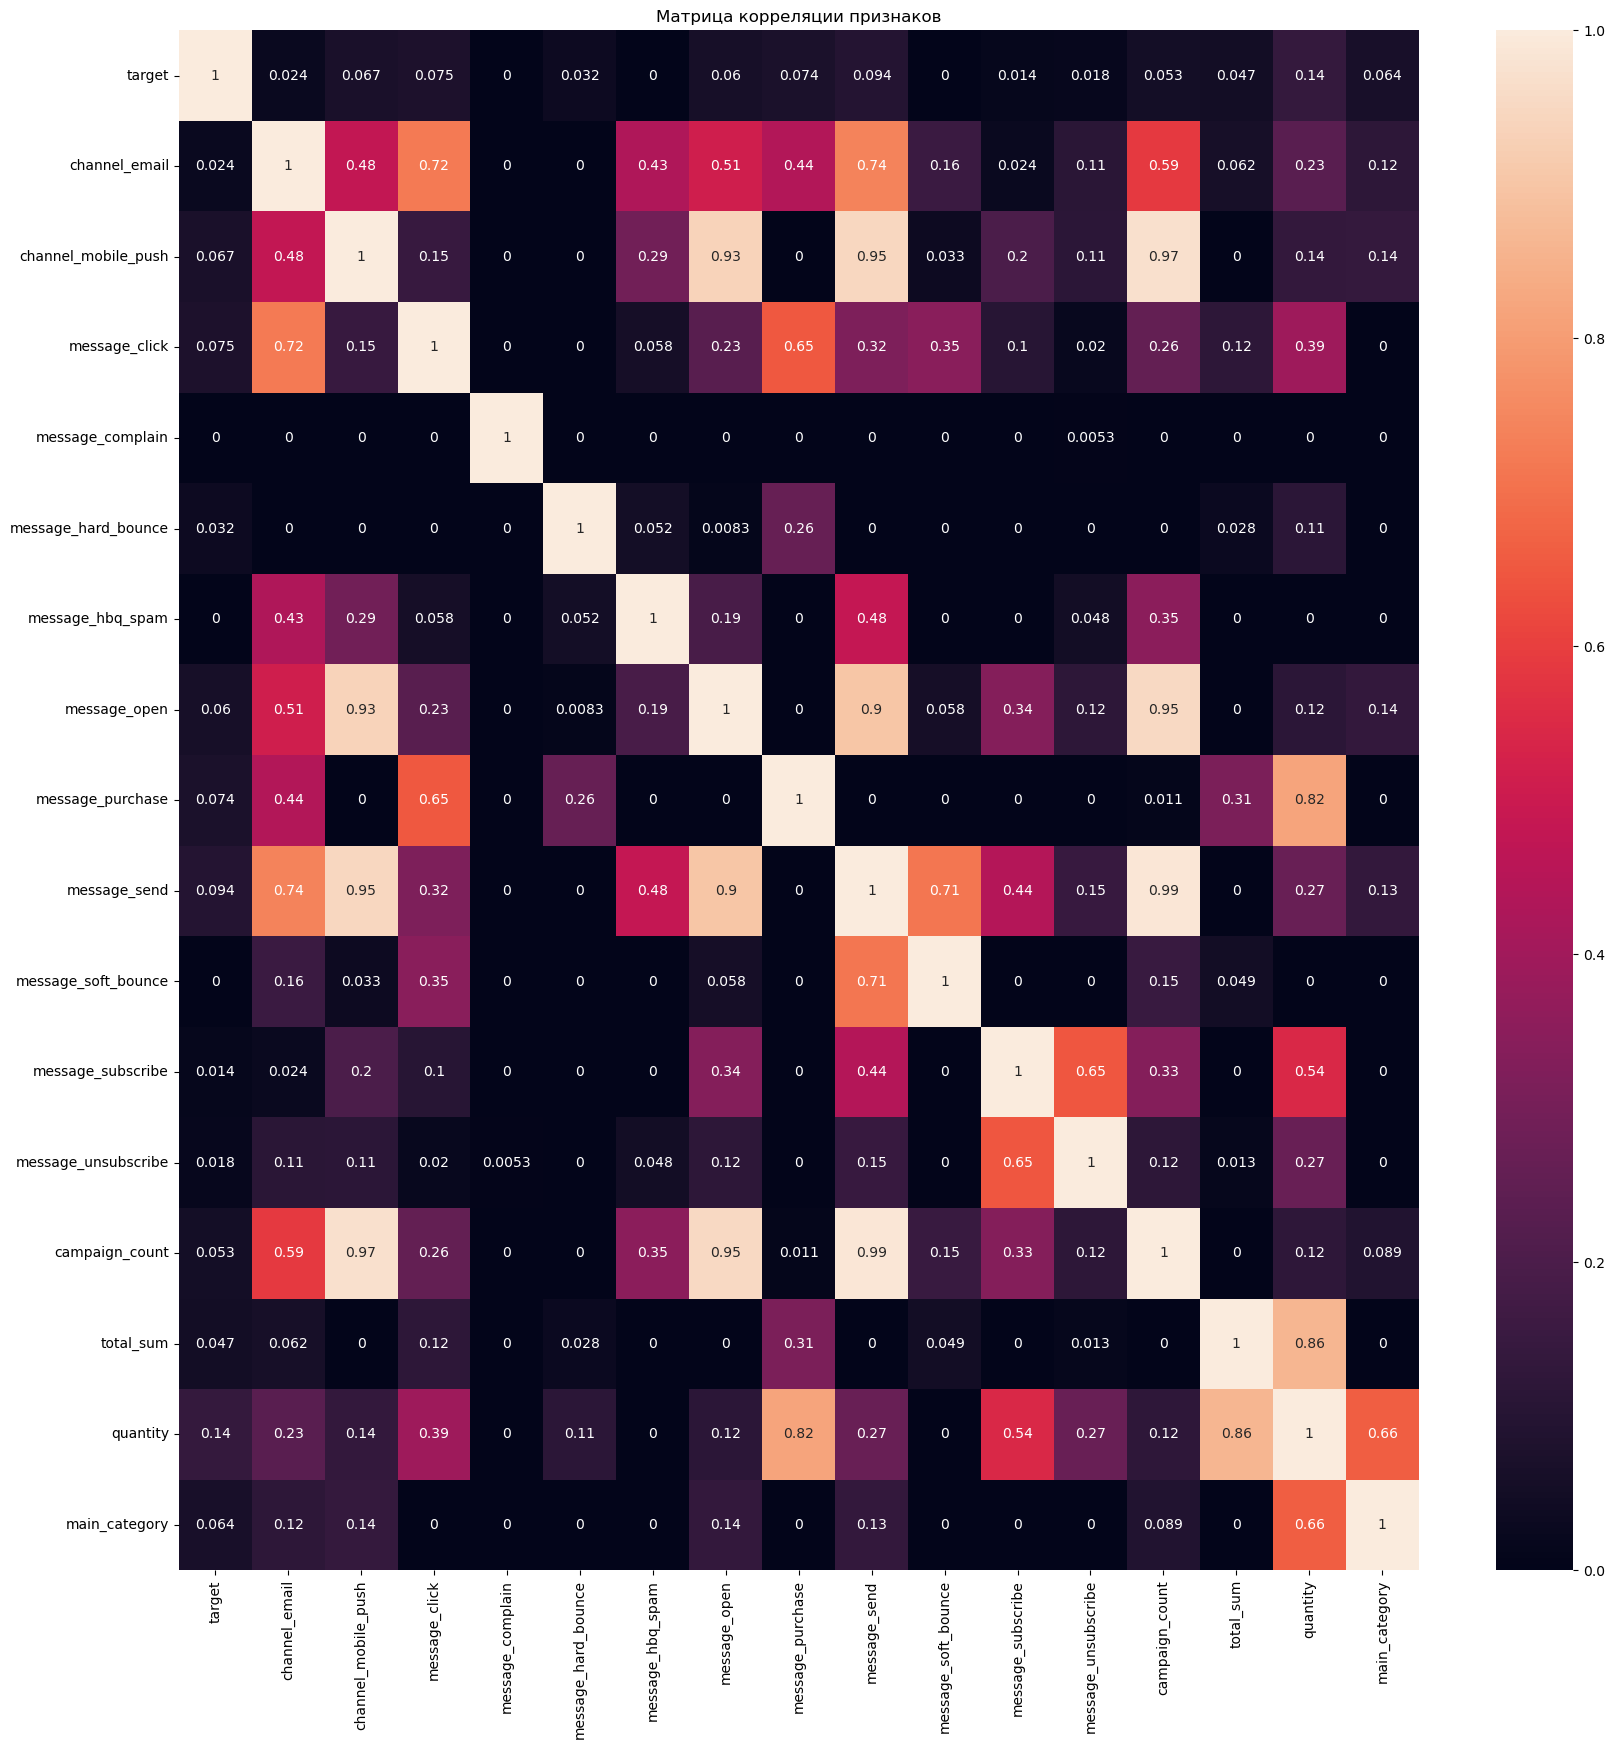

In [62]:
# построим матрицу корреляции для проверки данных на мультиколлинеарность

plt.figure(figsize=(20, 20))
sns.heatmap(target.phik_matrix(interval_cols=['channel_email', 'channel_mobile_push', 'message_click', 'message_complain',
                                                                          'message_hard_bounce', 'message_hbq_spam', 'message_open', 'message_purchase',
                                                                          'message_subscribe', 'message_unsubscribe', 'campaign_count', 'total_sum']),
annot=True)
plt.xticks(rotation=90)
plt.title('Матрица корреляции признаков')
plt.show()

In [63]:
#удалим признаки с мультиколлинеарностью 

target = target.drop(['channel_mobile_push', 'campaign_count'], axis=1)

<div style="background: #bbdb92">Матрица корреляции показывает, что наблюдается мультиколлинеарность в некоторых признаках (коээфициент 0.9 и выше). Удалили эти признаки ('channel_mobile_push', 'campaign_count', 'last_date_message'). Целевой признак слабо коррелирует со остальными признаками.
</div>

## Подготовка признаков и обучение моделей

<div style="background: #f5f7c4">Подготовим признаки и обучим модели для классификации пользователей. Качество будем оценивать метрикой roc_auc.

Целевой признак: target. Поскольку присутствует дисбаланс классов, будем стратифицировать выборку.
</div>

In [64]:
#разбиваем данные на тренировочную и тестовую выборки

X_train, X_test, y_train, y_test = train_test_split(
    target.drop(['target'], axis=1),
    target['target'],
    test_size = TEST_SIZE, 
    random_state = RANDOM_STATE,
    stratify = target['target']
)

In [65]:
# размер выборок

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((31468, 14), (31468,), (10490, 14), (10490,))

In [66]:
target.head()

,target,channel_email,message_click,message_complain,message_hard_bounce,message_hbq_spam,message_open,message_purchase,message_send,message_soft_bounce,message_subscribe,message_unsubscribe,total_sum,quantity,main_category
0,0,177,10,0,0,0,35,5,126,0,0,1,4795,5,4
1,1,165,5,0,0,0,5,1,154,0,0,0,14135,6,4
2,0,182,8,0,2,0,51,0,215,0,0,0,299,1,4
3,0,0,1,0,1,0,157,1,267,1,0,0,1049,1,4
4,0,202,16,0,0,0,31,3,243,0,0,0,14102,8,4


In [67]:
#создаём списки с названиями признаков

ohe_columns = X_train.select_dtypes(exclude='number').columns
num_columns = X_train.select_dtypes(include='number').columns

In [68]:
#cоздаём пайплайн для подготовки признаков из списка ohe_columns:

ohe_pipe = Pipeline(
    [
        ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False))
    ]
 )
print(ohe_pipe)

Pipeline(steps=[('ohe',
                 OneHotEncoder(drop='first', handle_unknown='ignore',
                               sparse_output=False))])


In [69]:
#создаём общий пайплайн для подготовки данных

data_preprocessor = ColumnTransformer(
    [
        ('ohe', ohe_pipe, ohe_columns),
        ('num', MinMaxScaler(), num_columns)
    ], 
    remainder = 'passthrough'
)
print(data_preprocessor)

ColumnTransformer(remainder='passthrough',
                  transformers=[('ohe',
                                 Pipeline(steps=[('ohe',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 Index(['main_category'], dtype='object')),
                                ('num', MinMaxScaler(),
                                 Index(['channel_email', 'message_click', 'message_complain',
       'message_hard_bounce', 'message_hbq_spam', 'message_open',
       'message_purchase', 'message_send', 'message_soft_bounce',
       'message_subscribe', 'message_unsubscribe', 'total_sum', 'quantity'],
      dtype='object'))])


In [70]:
# создаём итоговый пайплайн: подготовка данных и модель

pipe_final = Pipeline(
    [
        ('preprocessor', data_preprocessor),
        ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
    ])
print(pipe_final)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  Index(['main_category'], dtype='object')),
                                                 ('num', MinMaxScaler(),
                                                  Index(['channel_email', 'message_click', 'message_complain',
       'message_hard_bounce', 'message_hbq_spam', 'message_open',
       'message_purchase', 'message_send', 'message_soft_bounce',
       'message_subscribe', 'message_unsubscribe', 'total_su

In [71]:
param_grid = [
    # словарь для модели DecisionTreeClassifier()
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth' : range(2,5),
        'models__max_features': range(2,5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
   
    # словарь для модели KNeighborsClassifier() 
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors' : range(2,5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']   
    },

    # словарь для модели CatBoostClassifier()
    {
        'models': [CatBoostClassifier(loss_function="Logloss")],
        'models__iterations': range(10, 100),
        'models__max_depth': range(1, 5),   
        'models__learning_rate':[0.5, 1],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
    
    # словарь для модели LGBMClassifier()
    {
        'models': [LGBMClassifier()],
        'models__max_depth': range(1, 15),
        'models__learning_rate':[0.1, 1],
        'models__n_estimators': range(25, 100),
        'models__num_leaves': range(20, 40),        
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    }
]

In [72]:
random_search = RandomizedSearchCV(
    pipe_final, 
    param_grid, 
    cv=5,
    scoring='roc_auc',
    random_state=RANDOM_STATE
)

In [73]:
random_search.fit(X_train, y_train)

[LightGBM] [Info] Number of positive: 508, number of negative: 24666


  File "D:\programs\Anaconda\Lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000765 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1297
[LightGBM] [Info] Number of data points in the train set: 25174, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.020180 -> initscore=-3.882700
[LightGBM] [Info] Start training from score -3.882700
[LightGBM] [Info] Number of positive: 508, number of negative: 24666
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001755 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1293
[LightGBM] [Info] Number of data points in the train set: 25174, number of used features: 28
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.020180 -> initscore=-3.882700
[LightGBM] [Info] Start training from score -3.882700
[LightGBM] [Info] Num

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('ohe',
                                                                               Pipeline(steps=[('ohe',
                                                                                                OneHotEncoder(drop='first',
                                                                                                              handle_unknown='ignore',
                                                                                                              sparse_output=False))]),
                                                                               Index(['main_category'], dtype='object')),
                                                                              ('num',
                                                                               MinMaxScaler(),
                                                                               Index(['channel_email', 'message_click', 'message_complain',
       'm...
                                         'models__max_depth': range(1, 5),
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               'passthrough']},
                                        {'models': [LGBMClassifier()],
                                         'models__learning_rate': [0.1, 1],
                                         'models__max_depth': range(1, 15),
                                         'models__n_estimators': range(25, 100),
                                         'models__num_leaves': range(20, 40),
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               'passthrough']}],
                   random_state=42, scoring='roc_auc')

In [74]:
print('Лучшая модель и её параметры:\n\n', random_search.best_estimator_)
print('Метрика roc_auc лучшей модели на тренировочной выборке:', random_search.best_score_)

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  Index(['main_category'], dtype='object')),
                                                 ('num', MinMaxScaler(),
                                                  Index(['channel_email', 'message_click', 'message_complain',
       'message_hard_bounce', 'message_hbq_spam', 'message_open',
       'message_purchase', 'message_send', 'message_soft_bounce',
       'message_subscribe', 

In [75]:
y_pred = random_search.best_estimator_.predict_proba(X_test)
print(f'Метрика roc_auc на тестовой выборке: {round(roc_auc_score(y_test, y_pred[:,1]), 2)}')

Метрика roc_auc на тестовой выборке: 0.7


<div style="background: #f5f7c4">Лучшая модель - LGBMClassifier.
<br>Метрика roc_auc на тренировочной выборке = 0.715.
<br>Метрика roc_auc на тестовой выборке = 0.7.                                                      
</div>

<div style="background: #bbdb92"><b>Выводы по разделу "Подготовка признаков и обучение моделей"</b>
<br><br>На данном этапе выполнили подготовку признаков и обучение моделей с помощью пайплайнов. 
<br><br>Обучили 5 моделей: DecisionTreeClassifier, KNeighborsClassifier, CatBoostClassifier, LGBMClassifier.
<br><br>Оценка моделей проводилась метрикой ROC-AUC.
<br><br>Лучшей моделью оказалась LGBMClassifier с метрикой на тестовой выборке - 0.7.
</div>

<div style="background: #bbdb92"><b>Общий вывод по проекту</b>
<br><br>Цель проекта - предсказать вероятность покупки в течение 90 дней.
<br><br>В ходе выполнения проекта выполнены:
    
- загрузка и ознакомление с данными,
- предварительная обработка,
- исследовательский анализ,
- разработка новых синтетических признаков,
- проверка на мультиколлинеарность,
- отбор финального набора обучающих признаков,
- выбор и обучение моделей,
- итоговая оценка качества предсказания лучшей модели.

По итогу получена адекватная модель LGBMClassifier, которая показывает неплохое значение ROC_AUC на тестовых данных: 0.7.

</div>

In [76]:
pip freeze > requirements.txt

Note: you may need to restart the kernel to use updated packages.
